# Analysis of the Relationship of North Sea Plankton with Environmental Conditions
## Imports & Plot-Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 15,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'legend.title_fontsize': 15
})

## Load and prepare data

In [2]:
file_path = r'data/NorthSeaPlanktonData.csv'
data = pd.read_csv(file_path, sep=';', nrows=61, parse_dates=['Date'], dayfirst=True)

# Environmental parameters
env_cols = ['Nitrite', 'Silicate', 'Phosphate', 'Total Organic Nitrogen', 'Ammonium', 'Nitrate', 'Temperature', 'Salinity', 'Oxygen', 'Turbidity', 'Fluorescence']
env_vars = data.iloc[:, 6:17]
env_vars.columns = env_cols

# Plankton groups
plankton_cols = {
    'Plankton A': 17,
    'Plankton B': 18,
    'Plankton C': 19,
    'Plankton D': 20,
    'Plankton E': 21
}
plankton_data = data.iloc[:, list(plankton_cols.values())]
plankton_data.columns = plankton_cols.keys()

# Meta data on sampling date, cruise (expedition), sampling station, and sampling water depth
meta = data[['Date', data.columns[3], data.columns[4], data.columns[5]]]
meta.columns = ['Date', 'Cruise', 'Station', 'Depth']

This is a dummy dataset representing plankton data from the North Sea. It includes measurements of plankton concentrations and associated environmental parameters. The hypothetical samples were taken during two research cruises at two sampling stations from different water depths, from the surface to the seabed. For the purposes of this analysis, the data from both stations were combined.

## Time Series Analysis

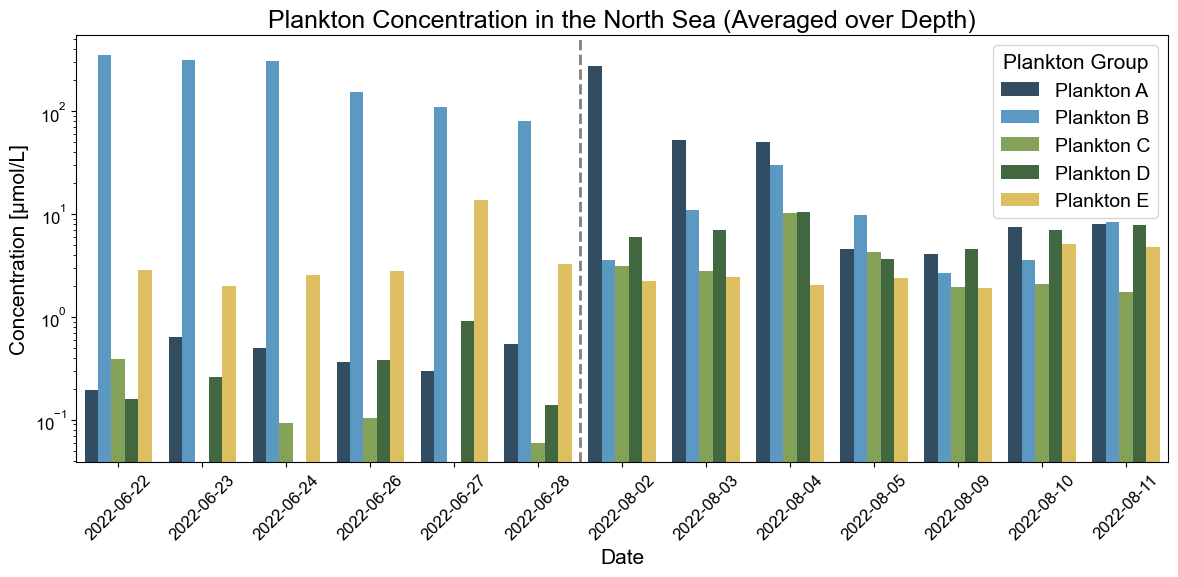

In [3]:
# Transforming table from wide to long format
df_wide = pd.concat([meta, plankton_data], axis=1)
df_long = df_wide.melt(id_vars=['Date', 'Depth', 'Cruise', 'Station'], var_name='Plankton Group', value_name='Concentration')
df_station1_avg = (
    df_long[df_long['Station'] == 'A']
    .groupby(['Date', 'Plankton Group'], as_index=False)['Concentration']
    .mean()
)

# Barplot
colors = ['#2A4D69', '#4B9CD3', '#88B04B', '#3B6E3A', '#F2C94C']
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_station1_avg, x='Date', y='Concentration', hue='Plankton Group', palette=colors)
plt.xticks(rotation=45)

# Horizontal line between cruises
vline_date = pd.Timestamp('2022-07-15')
xticklabels = [pd.to_datetime(label.get_text()) for label in ax.get_xticklabels()]
left_idx = max(i for i in range(len(xticklabels)) if xticklabels[i] <= vline_date)
right_idx = min(i for i in range(len(xticklabels)) if xticklabels[i] >= vline_date and i > left_idx)
x_pos = (left_idx + right_idx) / 2
plt.axvline(x=x_pos, color='gray', linestyle='--', linewidth=2)

# Labels
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Concentration [µmol/L]')
plt.title('Plankton Concentration in the North Sea (Averaged over Depth)')
plt.tight_layout()
plt.show()

The time series analysis reveals a clear shift in plankton community composition from June to August. While Plankton group B dominates in June, the community becomes more diverse by August, with Plankton groups A, C, and D showing substantial increases in abundance. In contrast, Plankton group E maintains a relatively stable concentration throughout the entire period.

## PCA

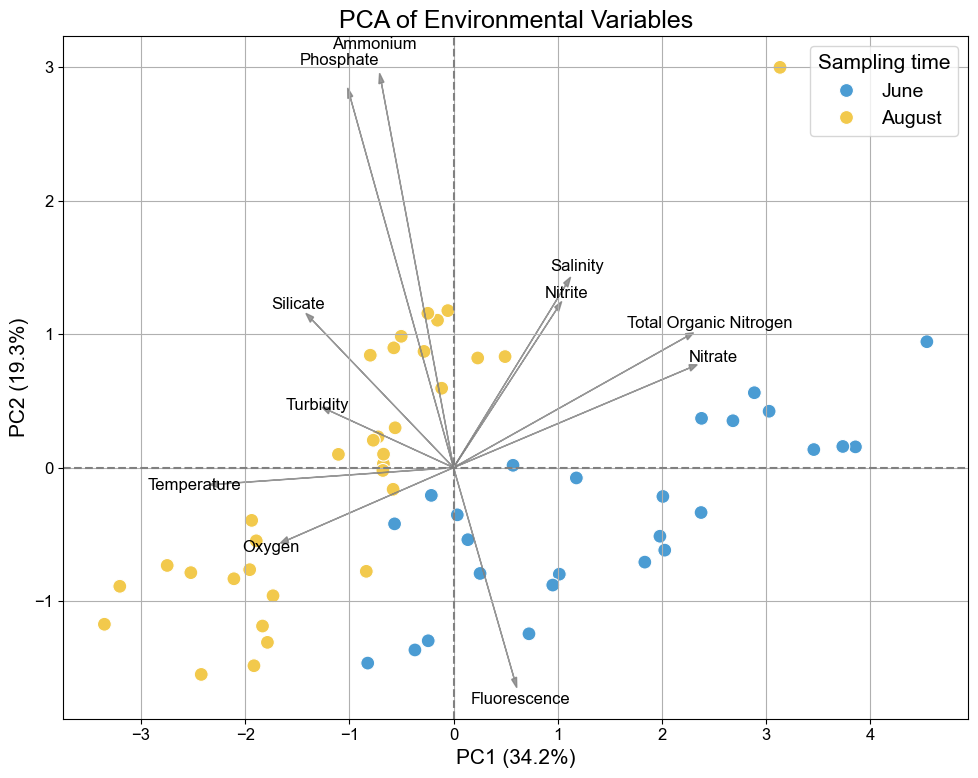

In [4]:
# PCA of entire dataset
df_pca_raw = pd.concat([env_vars, meta[['Cruise', 'Station']]], axis=1).dropna()
env_scaled = StandardScaler().fit_transform(df_pca_raw[env_cols])
pca = PCA(n_components=2)
scores = pca.fit_transform(env_scaled)
loadings = pca.components_.T

# Removing outliers with z score > 3
z_scores = np.abs(zscore(scores))
mask = (z_scores < 3).all(axis=1)
scores_filtered = scores[mask]
meta_filtered = df_pca_raw[['Cruise', 'Station']].iloc[mask]

# PCA Scatterplot
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    x=scores_filtered[:, 0], y=scores_filtered[:, 1],
    hue=meta_filtered['Cruise'],
    palette=['#4B9CD3', '#F2C94C'],
    s=100
)

# PCA Loadings
for i, var in enumerate(env_cols):
    plt.arrow(0, 0, loadings[i, 0]*5, loadings[i, 1]*5, color='gray', alpha=0.8, head_width=0.05)
    plt.text(loadings[i, 0]*5.5, loadings[i, 1]*5.5, var, ha='center', va='center', fontsize=12)

# Labels
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Environmental Variables")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
handles, labels = ax.get_legend_handles_labels()
label_map = {
    '2': 'June',
    '3': 'August'
}
new_labels = [label_map.get(label, label) for label in labels]
ax.legend(handles=handles, labels=new_labels, title='Sampling time')
plt.grid(True)
plt.tight_layout()
plt.show()

Principal component analysis (PCA) reveals that the two main components account for 53.5% of the variation in the dataset. While this is typical for biological data, it also indicates that nearly half of the variation is embedded in more complex, higher-order correlations. Despite this complexity, distinct patterns emerge. Notably, the PCA shows a clear separation between plankton communities and environmental conditions in June and August. June is characterized by high fluorescence, elevated nitrate concentrations, and increased levels of total organic nitrogen. In contrast, August is associated with higher concentrations of ammonium, phosphate, and silicate, along with increased turbidity and elevated temperatures.

## Correlation Matrix

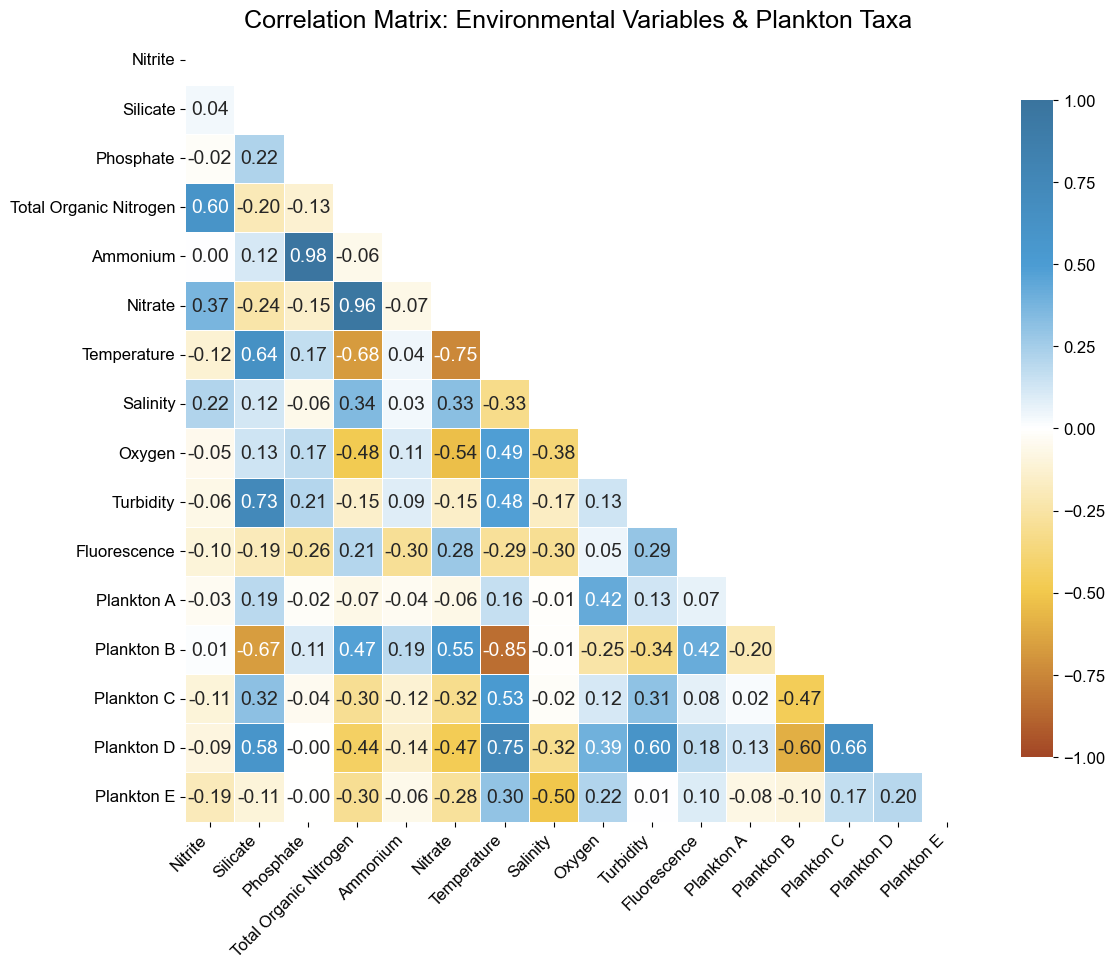

In [5]:
#Correlation Matrix
combined_df = pd.concat([env_vars, plankton_data], axis=1).dropna()
corr_matrix = combined_df.corr()

# Hiding upper triangle of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Color gradient
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#A34726','#F2C94C', '#ffffff', '#4B9CD3', '#3A749E',])
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

#Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap=custom_cmap, norm=norm, square=True, linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
#Labels
plt.title('Correlation Matrix: Environmental Variables & Plankton Taxa')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

An analysis of pairwise correlations over the entire time period reveals for example that Plankton group B is negatively correlated with silicate and temperature. As this group is dependent on silica as nutrient, the negative correlation manifests the efficient uptake of silicate by group B. The negative correlation of group B with temperature supports its dominance under cooler conditions in June.